In [1]:
class O :
    def __init__(self, v, args=None, args_1=None, variable=None) :
        self.value = v
        self.args = args
        self.args_1 = args_1
        self.variable = variable
        self.grad = 0.0
        
    def __str__(self) :
        return str(self.value)

In [2]:
def lift_function(f, df) :
    def new_f(x) :
        args = [v.value for v in x]
        c = f(*args)
        c_1 = df(*args)
        return O(c, x, c_1)
    
    return new_f

In [3]:
import math
f = lambda x, p : x**p
df = lambda x, p : [p * x ** (p-1), x**p * math.log(x)]
pow_lift = lift_function(f, df)

f = lambda *args : sum(args)
df = lambda *args : [1]*len(args)
add_lift = lift_function(f, df)

f = lambda x, y : x*y
df = lambda x, y : [y, x]
mult_lift = lift_function(f, df)

def sigmoid(v1) :
    e = pow_lift([O(math.e), mult_lift([O(-1), v1])])
    a = add_lift([O(1), e])
    return pow_lift([a, O(-1)])

f = lambda x : math.log(x)
df = lambda x : [1 / x]
log_lift = lift_function(f, df)

In [4]:
from collections import defaultdict
def grad(out) :
    if out.variable is not None :
        G = defaultdict(float, { out.variable : 1.0, 'G$': None})
        return G
    elif out.args is None :
        G = defaultdict(float)
        G['G$'] = None
        return defaultdict(float)
    else :
        G = defaultdict(float)
        G['G$'] = []
        for v, v_1 in zip(out.args, out.args_1) :
            G_v = grad(v)
            G['G$'].append(G_v)
            for k in G_v :
                if k != 'G$' :
                    G[k] += G_v[k] * v_1
                
        return G

In [42]:
def backward(out, grad_out=None) :
    if out.variable is not None :
        return
    elif out.args is None :
        return
    else :
        my_grad = (out.grad if grad_out is None else grad_out)
        for v, v_1 in zip(out.args, out.args_1) :
            v.grad += v_1 * my_grad
            
        for v in out.args :
            backward(v)

In [7]:
def LROutput(X, w) :
    out = []
    for x, y in zip(X, Y) :
        logit = add_lift([w[0], mult_lift([w[1], x])])
        p = sigmoid(logit)
        out.append(p)
        
    return out

def loss(out, Y) :
    loss = []
    for p, y in zip(out, Y) :
        if y.value == 1 :
            loss.append(log_lift([p]))
        else :
            loss.append(log_lift([add_lift([O(1), mult_lift([O(-1), p])])]))
            
    return mult_lift([O(-1/len(out)), add_lift(loss)])

In [8]:
import numpy as np
import pandas as pd
def logistic(x, b, noise=None):
    L = x.T.dot(b)
    if noise is not None:
        L = L+noise
    return 1/(1+np.exp(-L))

x = np.arange(-10., 10, 0.05)
bias = np.ones(len(x))
X = np.vstack([x,bias]) # Add intercept
B =  [1., 1.] # Sigmoid params for X

p = logistic(X, B)
# pnoisy = logistic(X, B, noise=np.random.normal(loc=0., scale=1., size=len(x)))
dichot = np.random.binomial(1., p)

In [9]:
w = [O(0, variable='b0'), O(0, variable='b1')]
X1 = [O(v) for v in X[0]]
Y = [O(v) for v in dichot]

In [10]:
out = LROutput(X1, Y)

In [53]:
from tqdm import tqdm_notebook
losses = []
for i in tqdm_notebook(range(1000)) :
    out = LROutput(X1, w)
    l = loss(out, Y)
    G = grad(l)
    w[0].value -= 0.1 * G['b0']
    w[1].value -= 0.1 * G['b1']
    losses.append(l.value)

In [48]:
from tqdm import tqdm_notebook
losses = []
for i in tqdm_notebook(range(1000)) :
    w[0].grad = 0.0
    w[1].grad = 0.0
    out = LROutput(X1, w)
    l = loss(out, Y)
    backward(l, 1)
    w[0].value -= 0.1 * w[0].grad
    w[1].value -= 0.1 * w[1].grad
    losses.append(l.value)

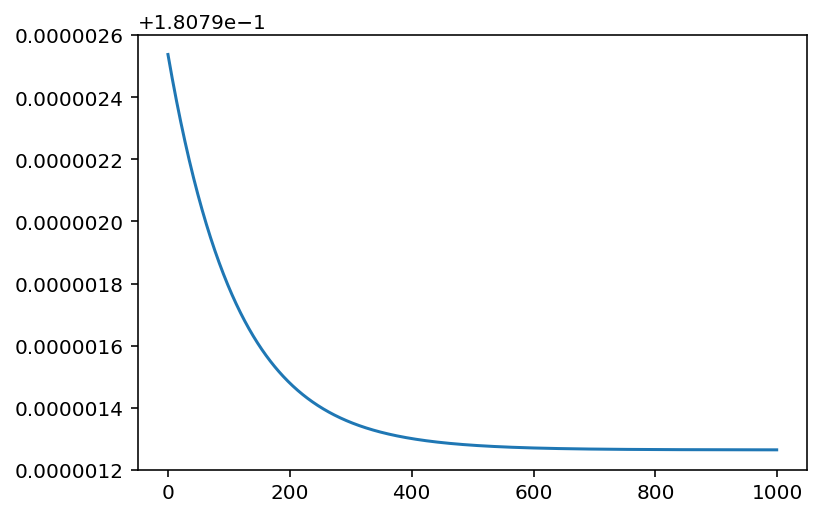

In [54]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [57]:
[x.value for x in w]

[0.7954664307659197, 0.9089652290287341]

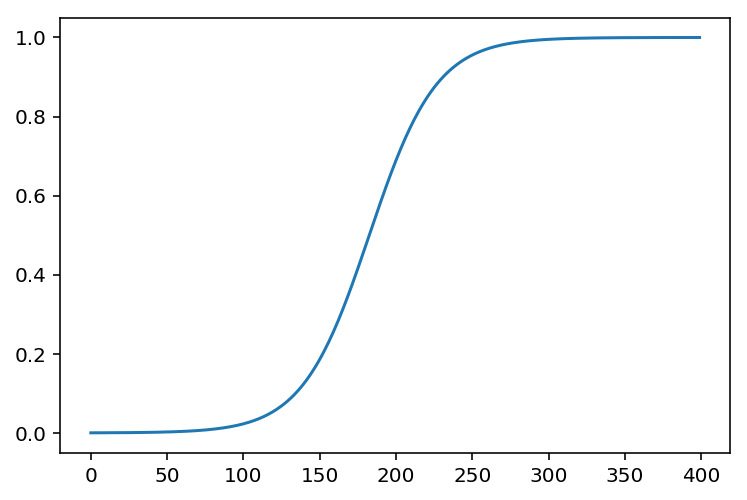

In [58]:
plt.plot([x.value for x in out])